#ResNet-Style models

In this colab we have built first a ResNet model from scratch using LSTM layers and then we moved to the real ResNet model by resizing and reshaping the sampls

##Loading dataset and importing libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


Loading the dataset and printing the number of samples for each class. We also calculate the class weight

In [ ]:
!unzip -q /gdrive/MyDrive/ANNDL/Homework2/training_dataset_homework2.zip

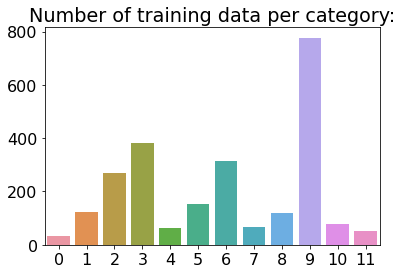

In [ ]:
x_data = np.load('x_train.npy')
y_data = np.load('y_train.npy')

classes = np.zeros(12)
for x in y_data:
  classes[x] +=1


import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x=np.arange(12), y=classes).set_title("Number of training data per category:")
weight = max(classes)/classes
class_weight = {}
for i in range(12):
  class_weight[i] = weight[i]
#print(class_weight)

Setting the seed for reproducibility

In [ ]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

##Preprocessing the data

We have used the MinMaxScaler for normalize the feature between -1 and 1.
We also print the time series for inspecting the data

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_data = x_data
for i in range(len(x_data)):
  scaler = scaler.fit(x_data[i])
  X_data[i]=scaler.transform(x_data[i])

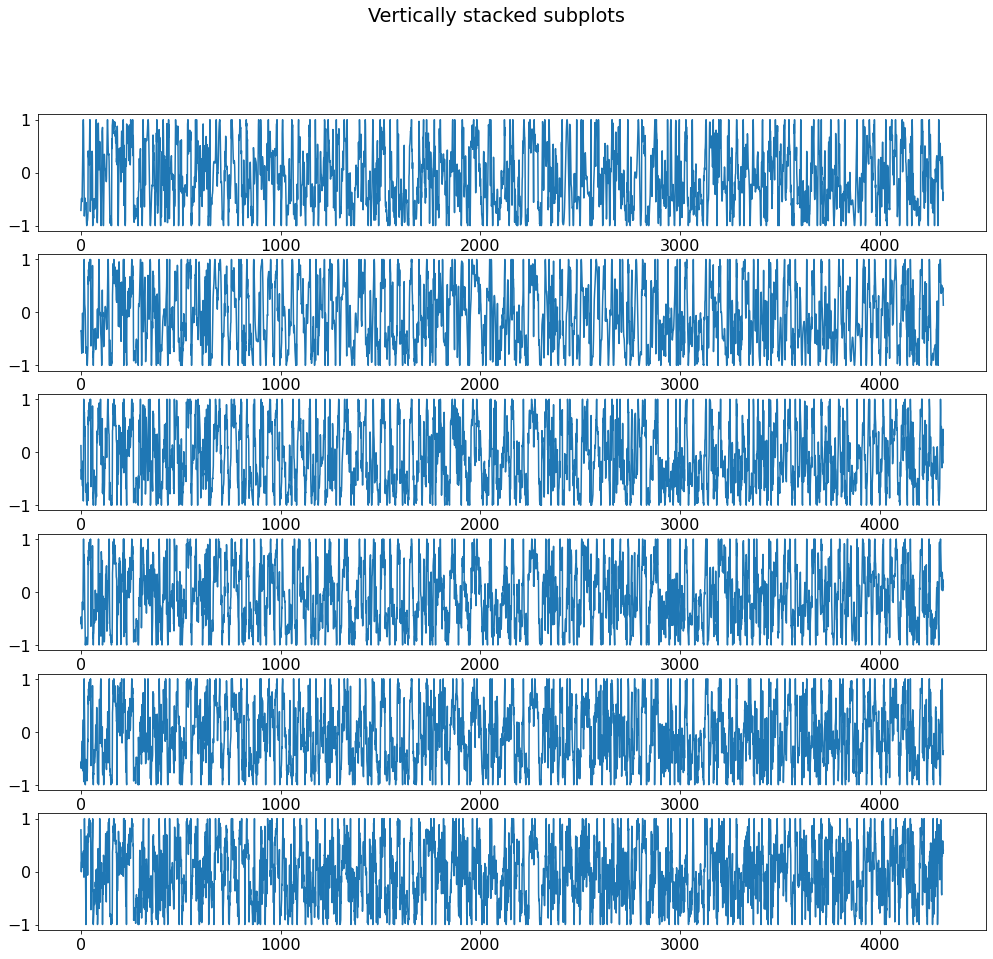

In [ ]:
fig, ax = plt.subplots(6, figsize=(17, 15))
fig.suptitle('Vertically stacked subplots')

for i in range(6):
  arr = []
  for x in range(len(y_data)):
    if y_data[x] == 8:
      arr = np.append(arr,(X_data[x,:,i]))
  ax[i].plot(arr)

Splitting the dataset between Training and Validation and setting the input shape and the batches for the training

In [ ]:
Y_data = tfk.utils.to_categorical(y_data)
print(X_data.shape)
print(Y_data.shape)

x_train, x_val, y_train, y_val = train_test_split(X_data, Y_data, test_size=0.2, shuffle= True)

(2429, 36, 6)
(2429, 12)


In [ ]:
input_shape = x_data.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 500

##Building ResNet-style model with LSTM

In [ ]:
def build_resnet(input_shape, nb_classes):
    n_feature_maps = 64

    input_layer = tfkl.Input(input_shape)

    middle_dropout = 0.1

    # BLOCK 1

    print("Before")
    print(input_layer.shape)
    conv_x = tfkl.LSTM(n_feature_maps, return_sequences=True)(input_layer)
    print(conv_x.shape)
    print("After")
    conv_x = tfkl.Activation('relu')(conv_x)
    conv_x = tfkl.Dropout(middle_dropout)(conv_x)

    conv_y = tfkl.LSTM(n_feature_maps, return_sequences=True)(conv_x)
    conv_y = tfkl.Activation('relu')(conv_y)
    conv_y = tfkl.Dropout(middle_dropout)(conv_y)

    conv_z = tfkl.LSTM(n_feature_maps, return_sequences=True)(conv_y)

    shortcut_y = tfkl.LSTM(n_feature_maps, return_sequences=True)(input_layer)

    output_block_1 = tfkl.add([shortcut_y, conv_z])
    output_block_1 = tfkl.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = tfkl.LSTM(n_feature_maps * 2, return_sequences=True)(output_block_1)
    conv_x = tfkl.Activation('relu')(conv_x)
    conv_x = tfkl.Dropout(middle_dropout)(conv_x)

    conv_y = tfkl.LSTM(n_feature_maps * 2, return_sequences=True)(conv_x)
    conv_y = tfkl.Activation('relu')(conv_y)
    conv_y = tfkl.Dropout(middle_dropout)(conv_y)

    conv_z = tfkl.LSTM(n_feature_maps * 2, return_sequences=True)(conv_y)

    shortcut_y = tfkl.LSTM(n_feature_maps * 2, return_sequences=True)(output_block_1)

    output_block_2 = tfkl.add([shortcut_y, conv_z])
    output_block_2 = tfkl.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = tfkl.LSTM(n_feature_maps * 2, return_sequences=True)(output_block_2)
    conv_x = tfkl.Activation('relu')(conv_x)
    conv_x = tfkl.Dropout(middle_dropout)(conv_x)

    conv_y = tfkl.LSTM(n_feature_maps * 2, return_sequences=True)(conv_x)
    conv_y = tfkl.Activation('relu')(conv_y)
    conv_y = tfkl.Dropout(middle_dropout)(conv_y)

    conv_z = tfkl.LSTM(n_feature_maps * 2, return_sequences=True)(conv_y)


    output_block_3 = tfkl.add([output_block_2, conv_z])
    output_block_3 = tfkl.Activation('relu')(output_block_3)

    # FINAL

    gap_layer = tfkl.GlobalAveragePooling1D()(output_block_3)

    gap_layer = tfkl.Dropout(0.3)(gap_layer)
    gap_layer = tfkl.Dense(512, activation='leaky_relu')(gap_layer)
    output_layer = tfkl.Dense(nb_classes, activation='softmax')(gap_layer)

    model = tfk.models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Building model and inspecting the layers

In [ ]:
model = build_resnet(input_shape, classes)
model.summary()

Before
(None, 36, 6)
(None, 36, 64)
After
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 36, 64)       18176       ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 36, 64)       0           ['lstm[0][0]']                   
                                                                                                  
 dropout (Dropout)              (None, 36, 64)       0           ['activation[0][0]']             
                                                    

Train the model

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    shuffle = True,
    class_weight = class_weight,
    validation_data=(x_val,y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
      ]
).history

Epoch 1/500
16/16 [==============================] - 23s 253ms/step - loss: 9.3996 - accuracy: 0.0932 - val_loss: 2.2468 - val_accuracy: 0.2243
Epoch 2/500
16/16 [==============================] - 1s 42ms/step - loss: 8.4829 - accuracy: 0.2234 - val_loss: 2.1310 - val_accuracy: 0.2305
Epoch 3/500
16/16 [==============================] - 1s 39ms/step - loss: 7.8456 - accuracy: 0.2126 - val_loss: 2.0071 - val_accuracy: 0.1790
Epoch 4/500
16/16 [==============================] - 1s 39ms/step - loss: 7.6456 - accuracy: 0.1755 - val_loss: 1.9983 - val_accuracy: 0.2058
Epoch 5/500
16/16 [==============================] - 1s 40ms/step - loss: 7.4426 - accuracy: 0.2434 - val_loss: 1.8760 - val_accuracy: 0.2284
Epoch 6/500
16/16 [==============================] - 1s 40ms/step - loss: 7.2708 - accuracy: 0.2512 - val_loss: 1.8802 - val_accuracy: 0.2510
Epoch 7/500
16/16 [==============================] - 1s 40ms/step - loss: 6.9719 - accuracy: 0.2496 - val_loss: 1.9302 - val_accuracy: 0.2510
Epoc

##Evaluating the model

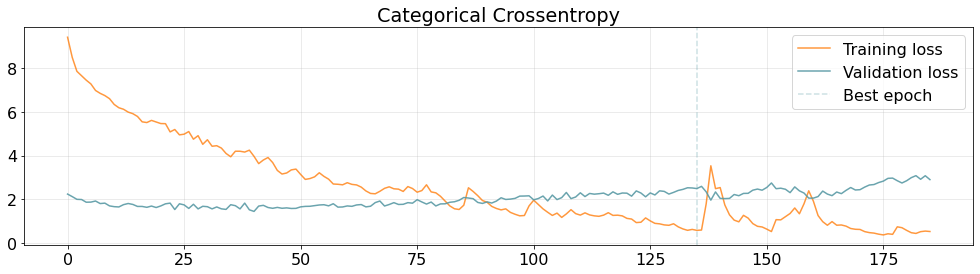

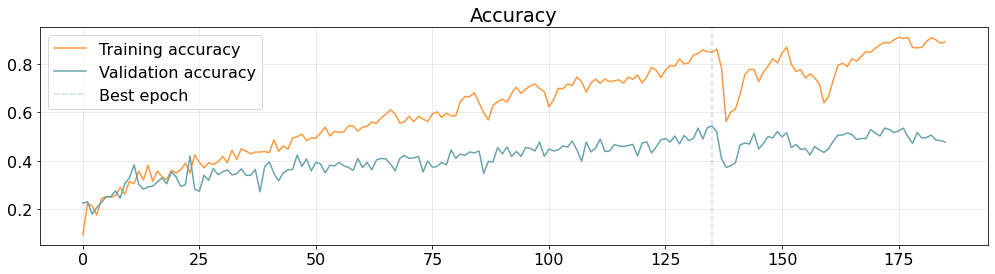

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = model.predict(x_val)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)
pp = np.argmax(y_val, axis=-1)
import sklearn.metrics
print(sklearn.metrics.classification_report(pp, predicted_classes,output_dict = False))

16/16 [==============================] - 3s 15ms/step
[ 4  8  9  9  9  2  9  9  9  8  3  6  6 10  2  9  9  3  8  6  6  2  7  3
  9  9  7  9  5  3  3  9  8  1  5  4  9  8  2  1  9  9  9  1  3  9  2  2
  4  2  4  9  8  6  8  9  5  9  6  9  8  5  6 10  9  9  8  9  9  9  2  6
  9  0 11  9  9  2  5  6  9 11  9  4  2  6 11  2  9  5  9  6  9  5  9  4
  5  2  6  2  6  9 10  9  3  3  9 10  6  9  4  9  6  8 10  9  2  6  9  9
  9  6  5 10  5  9  6  2  9  3  3  9 11  5  6  5  2  9  9  9  6  1  6  9
  9  8  9  2  5 10  8  9  9  9  8  2  9 11  9  2  8  5  2  9  9  9  6 10
  2  4  4  4  3  6  9  2  9  2  4  9  9  2  9  4  9 10  3  6  9  1  6  5
  9  9  3  9  0  3  8  3  9  5  1  2  4  7  3  3  8  1  8  7  2  9  7  6
 10  8  9  2  8  9  5  6 10 10  1  9  7  2  2 10  9  9  6  6  9  2  9  5
  6 11  2  7  6  5  9  6  5  9  2  9  9  3  9  3  9  9  9  9  5  2  9  9
  9  9  9  9  6  9  6 10  9  1  9  2  6  2  5  9  9  3  6  2  6  6  9  6
  9  6  9  9  6  1  3  3  9  9  9  5  4  7  8 11  5 11  1  9  9  9  9 

Accuracy: 0.5432
Precision: 0.4234
Recall: 0.4515
F1: 0.4313


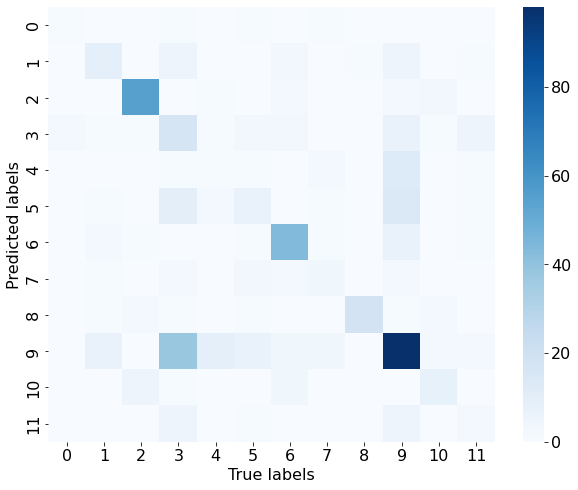

In [ ]:
y_test = y_val
x_test = x_val

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

##Building True ResNet model

Loading the ResNet with and without the imagenet weights and allow the training of the CNN

In [ ]:
def build_true_resnet(input_shape, nb_classes):

    print(input_shape)


    inputs = tfk.Input(input_shape)
    print(inputs.shape)
    x = tfkl.Reshape(target_shape=(36, 6, 1))(inputs)
    x = tfkl.Conv2D(filters=3, kernel_size=1)(x)
    print(x.shape)
    x = tf.keras.layers.Resizing( 36, 36, interpolation='bilinear', crop_to_aspect_ratio=True,) (x)

    print(x.shape)
    x = tfk.applications.ResNet50V2(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(36, 36, 3),
        include_top=False)(x)  # Do not include the ImageNet classifier at the top.



    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output_layer = tfkl.Dense(units=nb_classes, activation='softmax')(x)

    tl_model = tfk.Model(inputs, output_layer)

    tl_model.compile(optimizer=tfk.optimizers.Adam(),
                  loss=tfk.losses.CategoricalCrossentropy(),
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    tl_model.get_layer('resnet50v2').trainable = True

    tl_model.summary()

    return tl_model

In [ ]:
model = build_true_resnet(input_shape, classes)
model.summary()

(36, 6)
(None, 36, 6)
(None, 36, 6, 3)
(None, 36, 36, 3)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 36, 6)]           0         
                                                                 
 reshape_2 (Reshape)         (None, 36, 6, 1)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 6, 3)          6         
                                                                 
 resizing_2 (Resizing)       (None, 36, 36, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
  

In [ ]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    shuffle = True,
    class_weight = class_weight,
    validation_data=(x_val,y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        #tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
16/16 [==============================] - 19s 400ms/step - loss: 10.2107 - accuracy: 0.1034 - precision_2: 0.1618 - recall_2: 0.0057 - val_loss: 184.0927 - val_accuracy: 0.1276 - val_precision_2: 0.1276 - val_recall_2: 0.1276
Epoch 2/500
16/16 [==============================] - 1s 86ms/step - loss: 9.4472 - accuracy: 0.1791 - precision_2: 0.4444 - recall_2: 0.0309 - val_loss: 6070.2637 - val_accuracy: 0.0391 - val_precision_2: 0.0391 - val_recall_2: 0.0391
Epoch 3/500
16/16 [==============================] - 1s 87ms/step - loss: 8.5094 - accuracy: 0.2177 - precision_2: 0.5183 - recall_2: 0.0582 - val_loss: 24119.1699 - val_accuracy: 0.0267 - val_precision_2: 0.0268 - val_recall_2: 0.0267
Epoch 4/500
16/16 [==============================] - 1s 86ms/step - loss: 9.0986 - accuracy: 0.1925 - precision_2: 0.4563 - recall_2: 0.0484 - val_loss: 21135.5000 - val_accuracy: 0.0391 - val_precision_2: 0.0393 - val_recall_2: 0.0391
Epoch 5/500
16/16 [==============================] - 2s 

##Evaluating the model

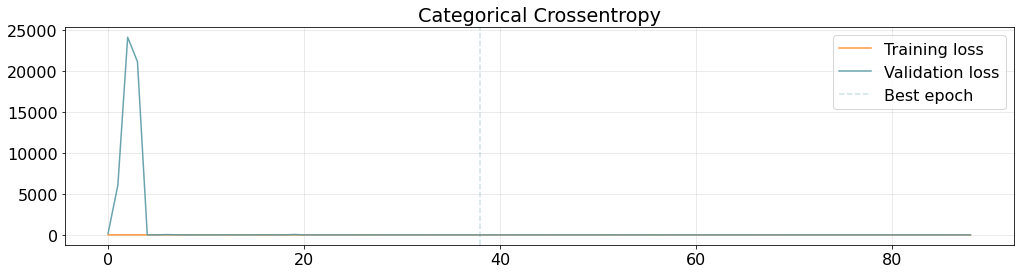

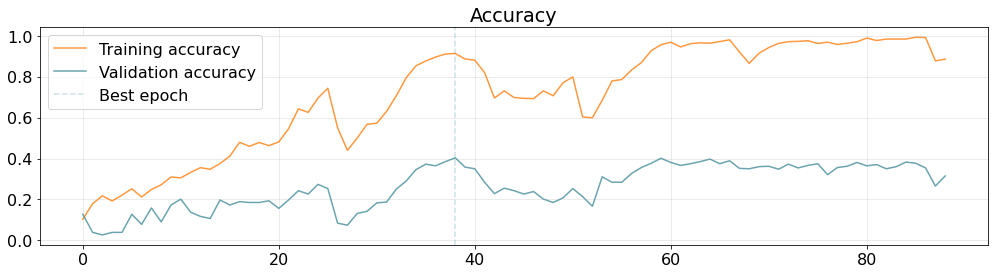

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = model.predict(x_val)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)
pp = np.argmax(y_val, axis=-1)
import sklearn.metrics
print(sklearn.metrics.classification_report(pp, predicted_classes,output_dict = False))

16/16 [==============================] - 2s 40ms/step
[11  8  9  8  3  2 11  6  3 11  9  6  6  6  2  9  1  3  2  6  3  2  9  4
  3  9  9  4 11  9  7  9  8  4  9  9  9  1  2  1  9  6  9  1 11  9 10  8
  4  2 11  9  8  6  6  9  3  6  6  9  3  9  6 10  9  9  2 11  9  9  2  6
  3  9 11  9  3  9  9  2  9 11  6  9  2  6 11  2  6  3  6  7  9  1  9  9
  1  2  9  2  5  9  2  9 10  9  9  2  6  9 11  9  2  9  6  9  9  6  3  9
  9  6  9  6  9  9  9  2  9  9  6  9 11  9  6 11  2 11  9  9  9  0  6  9
  9 11 11  6  9  9  2  9  3  3  6  2  6  9  6  2  8 11  9  9  3  9  6  9
  2  9  5  9  9  1  9 10  2  2  3  6  6  2  9  8  9  6 11  1  9  5  6  6
  5 11  3  9  9  4  8  3  9  9 11  2  3  2  9  3  2  1  8  7  2 11  2  6
  9  8  9  2  2  9  3  6  6  6  1  9  9  2  2  6  9  6  9  9  9  2  9 11
  1  2  6  7  5  6  9  6  4 11  2  9  5  6  9  9  9 11  1  4  3  2 11 11
  4  9  9 11  6  3  3  2  3  9  6  2  3  1  3  9  9  2 10  2  6  3  3  6
  9  6  9  9  6  9  9  9  9  2  6  9  1  9  8 11  9  7  6  8  9  3  9 

In [ ]:
y_test = y_val
x_test = x_val

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()